In [12]:
import io, os, sys, types

In [27]:
import nbformat
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell


In [22]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [23]:
class NotebookLoader(object):
    """Module Loader for IPython Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing notebook from %s" % path)
                                       
        # load the notebook object
        nb = nbformat.read(path, as_version=4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [24]:
class NotebookFinder(object):
    """Module finder that locates IPython Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [25]:
sys.meta_path.append(NotebookFinder())

importing notebook from pre_processing.ipynb
Populating the interactive namespace from numpy and matplotlib


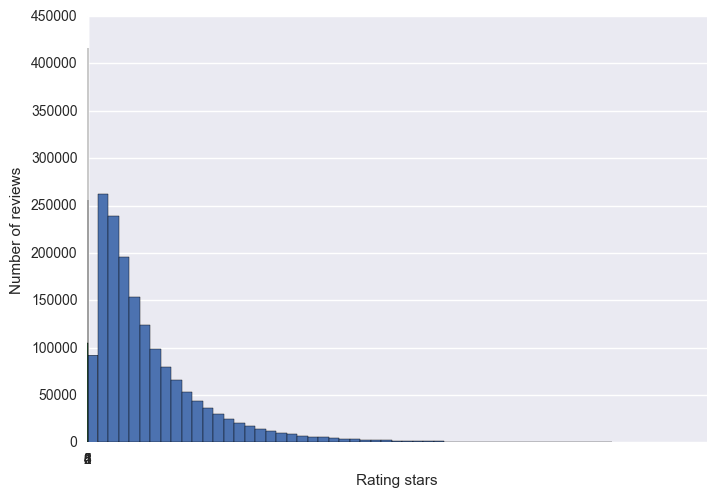

In [28]:
import pre_processing

In [29]:
print(pre_processing.review_data.head(10))

                                                text  stars_review
0  Mr Hoagie is an institution. Walking in, it do...             4
1  Excellent food. Superb customer service. I mis...             5
2  Yes this place is a little out dated and not o...             5
3  PROS: Italian hoagie was delicious.  Friendly ...             3
4  First the only reason this place could possibl...             2
5  Normally, I do not do reviews of an establishm...             1
6  I like this place a lot. It's a good toasted h...             4
7  This place was DELICIOUS!!  My parents saw a r...             5
8  Can't miss stop for the best Fish Sandwich in ...             5
9  This place should have a lot more reviews - bu...             5


In [31]:
pre_processing.review_data['predicted_rating'] = round(sum(pre_processing.review_data.stars_review)/len(pre_processing.review_data.index))

In [32]:
print "Baseline Rating:", round(sum(pre_processing.review_data.stars_review)/len(pre_processing.review_data.index))

Baseline Rating: 3.0


In [36]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
#from sklearn.metrics import classification_report

precision = metrics.precision_score(pre_processing.review_data.stars_review, pre_processing.review_data.predicted_rating)
recall = metrics.recall_score(pre_processing.review_data.stars_review, pre_processing.review_data.predicted_rating)
f1 = metrics.f1_score(pre_processing.review_data.stars_review, pre_processing.review_data.predicted_rating)
accuracy = accuracy_score(pre_processing.review_data.stars_review, pre_processing.review_data.predicted_rating)

baselineResult = {}

data = {'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy}

baselineResult['Baseline'] = data
pd.DataFrame(baselineResult).T

/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/piyushghai/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of sco

,accuracy,f1_score,precision,recall
Baseline,0.137875,0.033412,0.01901,0.137875
